In [31]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import importlib
import shutil
import platform

OSX = platform.system()

from scipy.interpolate import make_interp_spline

import sys
if OSX == 'Darwin':
    sys.path.append('/Users/psummers8/Documents/MITgcm/MITgcm/elizaScripts/main_scripts')

import build_domain_funcs as build_domain 
import run_config_funcs as rcf # import helpter functions

## Main run configuration

In [33]:
# set high level run configurations

run_config = {}
run_config['ncpus_xy'] = [1, 1] # cpu distribution in the x and y directions
run_config['run_name'] = 'shelfTest'
run_config['ndays'] = 20 # simulaton time (days)
run_config['test'] = True # if True, run_config['nyrs'] will be shortened to a few time steps

run_config['horiz_res_m'] = 500 # horizontal grid spacing (m)
run_config['Lx_m'] = 25000 # domain size in x (m)
run_config['Ly_m'] = 6000 # domain size in y (m)
# NOTE: the number of grid points in x and y should be multiples of the number of cpus.

run_config['evolve_salt'] = False
run_config['use_GMRedi'] = False # should be set to false for eddy permitting resolutions
run_config['periodic_forcing'] = False # note: the code is not yet set up to handle time-dependent forcing

MITgcm_release = 'MITgcm-checkpoint69a' #Sept 2024 release
#MITgcm_code_dir = os.path.join(group_home_dir, 'shared/mitgcm_releases', MITgcm_release)

# you probably don't need to touch this
run_config['use_MPI'] = False # for multi-processing
run_config['lf'] = '\r\n' # linebreak characters 
if OSX == 'Darwin':
    run_config['exps_dir'] = os.path.join('/Users/psummers8/Documents/MITgcm/MITgcm/experiments') 
run_config['run_dir'] = os.path.join(run_config['exps_dir'], run_config['run_name'])
print('run_config is', run_config)

run_config is {'ncpus_xy': [1, 1], 'run_name': 'shelfTest', 'ndays': 20, 'test': True, 'horiz_res_m': 500, 'Lx_m': 25000, 'Ly_m': 6000, 'evolve_salt': False, 'use_GMRedi': False, 'periodic_forcing': False, 'use_MPI': False, 'lf': '\r\n', 'exps_dir': '/Users/psummers8/Documents/MITgcm/MITgcm/experiments', 'run_dir': '/Users/psummers8/Documents/MITgcm/MITgcm/experiments/shelfTest'}


## Generate new experiment directory and copy over defaults

In [3]:
# create experimentary directory on SCRATCH and copy over default configuration
# NOTE: this step does not overwrite existing directories. 
run_subdir_list = ['build', 'code', 'input', 'results']
for subdir in run_subdir_list:
    run_config['%s_dir'% subdir] = os.path.join(run_config['run_dir'], subdir)
    os.makedirs(run_config['%s_dir'% subdir], exist_ok=True)
     
# copy over defaults
if OSX == 'Darwin':
    default_dirs = os.listdir('/Users/psummers8/Documents/MITgcm/MITgcm/DEFAULT_Shelf/')
for dir00 in default_dirs:
    print(dir00)
    if dir00.startswith('.'):
        continue
        
    if OSX == 'Darwin':
            default_dir = '/Users/psummers8/Documents/MITgcm/MITgcm/DEFAULT_Shelf/%s/'%dir00
    default_files = os.listdir(default_dir)
    dst_dir = os.path.join(run_config['run_dir'], dir00)
    
    for file in default_files:

        if file.startswith('.'):
            continue
        else:
            src_fpath = os.path.join(default_dir, file)
            shutil.copy2(src_fpath, dst_dir)
            #print(src_fpath, '>', dst_dir)

.DS_Store
input
code
results
build


In [4]:
print(run_config['run_dir'])
print(os.listdir(run_config['run_dir']))

/Users/psummers8/Documents/MITgcm/MITgcm/experiments/shelfTest
['input', 'code', 'results', 'build']


In [5]:
# create new analysis sub-dir in your home directory
if OSX == 'Darwin':
    analysis_dir = '/Users/psummers8/Documents/MITgcm/MITgcm/analysis/%s'%run_config['run_name']
os.makedirs(analysis_dir, exist_ok=True)
print(analysis_dir)
os.getcwd()

/Users/psummers8/Documents/MITgcm/MITgcm/analysis/shelfTest


'/Users/psummers8/Documents/MITgcm/MITgcm/elizaScripts'

## Domain  and grid parameters

In [6]:
secsInDay = 24*60*60
secsInYear = 365*secsInDay


# set domain size
domain_params = {}
domain_params['Lx'] = run_config['Lx_m'] # domain size in x (m)
domain_params['Ly'] = run_config['Ly_m'] # domain size in y (m)
domain_params['L_sponge'] = 5000 # width of eastern sponge layer (m)
domain_params['H'] = 200 # max domain depth (m)

In [7]:
#---grid parameters ---# 

# NOTE: the only thing you may need to change here is the number of z-grid points)
grid_params = {}

grid_params['nSx'] = 1 # num of tiles per processor in x-direction
grid_params['nSy'] = 1 # num of tiles per processor in y-direction
grid_params['nTx'] = 1 # num of threads per processor in x-direction
grid_params['nTy'] = 1 # num of threads per processor in y-direction
grid_params['OLx'] = 3 # num of overlapping x-gridpoints per tile
grid_params['OLy'] = 3 # num of overlapping y-gridpoints per tile
grid_params['Nr'] = 40 # num of z-grid points

grid_params['nPx'] = run_config['ncpus_xy'][0] #num of processors in x-direction
grid_params['nPy'] = run_config['ncpus_xy'][1] #num of processors in x-direction

# grid_params['nSx'] = domain_params['Lx']/(run_config['horiz_res_m']) # num of x points in sub grid
# grid_params['nSy'] = domain_params['Ly']/(run_config['horiz_res_m']) # num of y points in sub grid

# grid_params['Nx'] = grid_params['sNx'] * grid_params['nSx'] * grid_params['nPx']
# grid_params['Ny'] = grid_params['sNy'] * grid_params['nSy'] * grid_params['nPy']

grid_params['Nx'] = domain_params['Lx']/(run_config['horiz_res_m']) # num of x points
grid_params['Ny'] = domain_params['Ly']/(run_config['horiz_res_m']) # num of y points

print("Nx: %s" %grid_params['Nx'])
print("Ny: %s" %grid_params['Ny'])

grid_params['sNx'] = grid_params['Nx']/grid_params['nPx']#num of x-gridpoints per tile
grid_params['sNy'] = grid_params['Ny']/grid_params['nPy'] #num of y-gridpoints per tile

print("sNx: %s" %grid_params['sNx'])
print("sNy: %s" %grid_params['sNy'])

# NOTE: sNx and sNy should be whole numbers/integers. As long we keep the horizontal resolution,
# domain dimesions, and number of cpus to be multiples of five, we should be ok. 

for key, param  in grid_params.items():
    assert param%1==0, "grid parameter needs to be an integer"
    grid_params[key] = int(param)
    
print(grid_params)
#run_config['grid_params'] = grid_params

Nx: 50.0
Ny: 12.0
sNx: 50.0
sNy: 12.0
{'nSx': 1, 'nSy': 1, 'nTx': 1, 'nTy': 1, 'OLx': 3, 'OLy': 3, 'Nr': 40, 'nPx': 1, 'nPy': 1, 'Nx': 50, 'Ny': 12, 'sNx': 50, 'sNy': 12}


In [8]:
# grid_params cont'd
grid_params['usingCartesianGrid'] = True
grid_params['usingSphericalPolarGrid'] = False 

# horizontal grid spacing
grid_params['delX'] = (domain_params['Lx']/grid_params['Nx'])*np.ones(grid_params['Nx'])
grid_params['delY'] = (domain_params['Ly']/grid_params['Ny'])*np.ones(grid_params['Ny'])


# vertical grid spacing 
# spacing increases with depth---can be modified
zidx = np.arange(1, grid_params['Nr']+1)
aa = 10
dz1 = 2*domain_params['H']/grid_params['Nr']/(aa+1)
dz2 = aa*dz1
dz = dz1 + ((dz2-dz1)/2)*(1+np.tanh((zidx-((grid_params['Nr']+1)/2))/aa))
zz1 = np.append([0], np.cumsum(dz))
zz = -(zz1[:-1] + np.diff(zz1)/2) # layer midpoints

grid_params['delZ'] = dz
grid_params['hFacMinDr'] = dz.min()


## Physical parameters

In [9]:
#---physical params---#

params01 = {} 

# physical constants
g = 9.81 # acc. due to gravity (m/s**2)
Omega = 2*np.pi*366/365/86400 # planetary rotation rate 
Rp = 6400*1000 # planetary radius (m)
lat_min = -70 # latitude at southern boundary (degrees)
#f0 = 2*Omega*np.sin(np.deg2rad(lat_min)) # coriolis param (1/s)
#beta = (2*Omega*np.cos(np.deg2rad(lat_min))/Rp) # beta param


# momentum scheme
params01['vectorInvariantMomentum'] = True

#Note: here and elsewhere, we need to be explicit about floats vs ints. E.g., use 12.0 to represent float and
# 12 for int

f0=0.
beta=0.E-11

# viscosity parameters
params01['viscA4'] = 0.0000 # Biharmonic viscosity?
params01['viscAz'] = 1.0e-3 # Vertical viscosity
params01['viscAh'] = 2.5e-1 # Vertical viscosity
#params01['viscC2smag'] = 2.2 # ??? viscosity

# advection and time stepping
params01['tempAdvScheme'] = 33 # needs to be int
params01['saltAdvScheme'] = 33 # needs to be int
#params01['tempStepping'] = True
#params01['saltStepping'] = run_config['evolve_salt']
params01['staggerTimeStep'] = True

# diffusivity
params01['diffK4T'] = 0.0e4 # ?? temp diffusion
params01['diffKhT'] = 2.5e-1 # Horizontal temp diffusion
params01['diffKzT'] = 2.0e-5 # Vertical temp diffusion
params01['diffK4S'] = 0.0e4 # ?? salt diffusion
params01['diffKhS'] = 2.5e-1 # Horz salt diffusion
params01['diffKzS'] = 2.0e-5 # Horz salt diffusion


# equation of state
params01['eosType'] = 'JMD95Z'
# params01['eosType'] = 'LINEAR'
# params01['tAlpha'] = 0.4e04
# params01['sBeta'] = 8.0e-4
params01['Tref'] = np.ones(grid_params['Nr'])*0. #ref temp
params01['Sref'] = np.ones(grid_params['Nr'])*34. #ref salt

# boundary conditions
#params01['bottomDragLinear'] = 0.0e-4

params01['no_slip_sides'] = True
params01['no_slip_bottom'] = True
params01['rigidLid'] = True
params01['implicitFreeSurface'] = False
params01['implicitViscosity'] = True
params01['implicitDiffusion'] = True

# physical parameters
params01['f0'] = 1.5e-4
params01['beta'] = 0.0e-13
params01['gravity'] = g

# misc
params01['selectAddFluid'] = 0
params01['hFacMin'] = 0.05
params01['nonHydrostatic'] = True
params01['readBinaryPrec'] = 64
params01['plotLevel'] = 0

# AS: Don't allow partial cell height to fall below min grid spacing
#params01['hFacMinDr'] = np.min(dz)

## Check for numericl stability?

## Numeric solvers and I/O controls

In [10]:
# numeric solver parameters 

params02 = {}
params02['cg2dMaxIters'] = 300
params02['cg2dTargetResidual'] = 1e-13
params02['cg3dMaxIters'] = 20
params02['cg3dTargetResidual'] = 1e-8

# time stepping parameters 
params03 = {}
params03['nIter0'] = 0
#params03['endTime'] = 864000.0
deltaT = 20.0
params03['abEps'] = 0.1

#if run_config['testing']:
    
params03['chkptFreq'] = 0.0
params03['pChkptFreq'] = 0.0
params03['taveFreq'] = 0.0
params03['dumpFreq'] = 86400.0
params03['taveFreq'] = 0.0
params03['monitorFreq'] = 86400.0
params03['monitorSelect'] = 1


params03['periodicExternalForcing'] = False
params03['ExternForcingPeriod'] = 100.0
params03['ExternForcingCycle'] = 1000.0 

In [11]:
if run_config['test']:
    nTimeSteps = 10
else:
    nTimeSteps = np.ceil(run_config['ndays']*secsInDay/detlaT)

simTimeAct = nTimeSteps*deltaT

params03['endTime'] = int(params03['nIter0']*deltaT+simTimeAct)
params03['deltaT'] = np.round(deltaT)
grid_params['Nt'] = nTimeSteps

## Create 'data' files

In [12]:
# NOTE: These steps generate the data text files located int the input directory

In [13]:
# gather params for data file 
params04 = {} #<-- using params04 to be consistent with ordering in Andrew's code
params04['usingCartesianGrid'] = grid_params['usingCartesianGrid']
params04['usingSphericalPolarGrid'] = grid_params['usingSphericalPolarGrid']
params04['delX']  = grid_params['delX']
params04['delY'] = grid_params['delY']
params04['delZ'] = dz

In [14]:
# get data fnames param
params05 = {}
params05['bathyFile'] ='topog.slope'
params05['hydrogThetaFile'] = 'T.init'
params05['hydrogSaltFile'] = 'S.init'


In [15]:
data_params = [params01, params02, params03, params04, params05]
rcf.write_data(run_config, data_params, group_name='data', lf=run_config['lf'])

## Make SIZE.h File

In [16]:
# generate size.h file
rcf.createSIZEh(run_config, grid_params)

## Specifiy relaxation of temperature and salinity 

In [17]:
OBCS = {}

## Set boundary conditions

## Specify Diagnostics

In [18]:
# Here we specify variables that should saved (i.e., written to disk) at various time intervals

# adjust output frequency
if run_config['test']:
    run_config['inst_freq'] = 1 # multiples of timestep
    run_config['tavg_freq'] = 1 # multiples of timestep
    
else:
    run_config['inst_freq'] = 1 # multiples of day
    run_config['tavg_freq'] = 1 # multiples of day


#---------specify time averaged fields------#
# NOTE: many more options available see mitgcm docs
diag_fields_avg = [['THETA','SALT','UVEL','WVEL','VVEL'],['UVELSLT ','UVELTH  ','WVELSLT ','WVELTH  '],['SHIfwFlx','SHIhtFlx','SHIForcT','SHIForcS'],['SHIgammT','SHIgammS','SHIuStar']]
diag_fields_max = 0
diag_fields_avg_name = ['dynDiag','fluxDiag','SHIflux','SHIgamma']
# diag_fields_avg = ['UVEL', 'VVEL', 'WVEL', 'UVELSQ', 'VVELSQ', 'WVELSQ',
#                   'UVELTH', 'VVELTH', 'WVELTH', 'THETA', 'THETASQ',
#                   'PHIHYD', 'LaUH1TH', 'LaVH1TH', 'LaHw1TH','LaHs1TH']

numdiags_avg = len(diag_fields_avg)
numdiags_avg_total = 0
for i in range(len(diag_fields_avg)):
    numdiags_avg_total += len(diag_fields_avg[i])
diag_phase_avg = 0.0

if run_config['test'] == True:
    diag_freq_inst = -run_config['inst_freq']*deltaT # negative values indicate snapshots at given interval
    diag_freq_avg = run_config['tavg_freq']*deltaT # positive values indicate time average over specified interval
else:
    diag_freq_inst = -run_config['inst_freq']*secsInDay
    diag_freq_avg = run_config['tavg_freq']*secsInDay
    
    
diag_params01 = {}
diag_params01['diag_mnc'] = False #<---you would need to modify this if you want netcdf output

for ii in range(numdiags_avg):  
    n = ii+1
    if len(diag_fields_avg[ii]) > diag_fields_max:
        diag_fields_max = len(diag_fields_avg[ii])
    diag_params01['fields(1:%i,%s)'%(len(diag_fields_avg[ii]),n)] ="','".join(diag_fields_avg[ii])
    diag_params01['fileName(%s)'%n] = diag_fields_avg_name[ii]
    diag_params01['frequency(%s)'%n] = diag_freq_avg
    diag_params01['timePhase(%s)'%n] = diag_phase_avg

    
#--------specify instanteous fields (i.e. snapshots)--------#
diag_fields_inst = [['UVEL', 'VVEL', 'WVEL','THETA','SALT']]
diag_fields_names = ['dynDiag']
numdiags_inst = len(diag_fields_inst)
diag_phase_inst = 0.0

for ii in range(numdiags_inst):
    n = numdiags_avg+ii+1
    if len(diag_fields_inst[ii]) > diag_fields_max:
        diag_fields_max = len(diag_fields_inst[ii])
    diag_params01['fields(1:%i,%s)'%(len(diag_fields_inst[ii]),n)] = "','".join(diag_fields_inst[ii])
    diag_params01['fileName(%s)'%n] = diag_fields_names[ii] + '_inst'
    diag_params01['frequency(%s)'%n] = diag_freq_inst
    diag_params01['timePhase(%s)'%n] = diag_phase_inst
    
print(diag_params01)
Ndiags = n

{'diag_mnc': False, 'fields(1:5,1)': "THETA','SALT','UVEL','WVEL','VVEL", 'fileName(1)': 'dynDiag', 'frequency(1)': 20.0, 'timePhase(1)': 0.0, 'fields(1:4,2)': "UVELSLT ','UVELTH  ','WVELSLT ','WVELTH  ", 'fileName(2)': 'fluxDiag', 'frequency(2)': 20.0, 'timePhase(2)': 0.0, 'fields(1:4,3)': "SHIfwFlx','SHIhtFlx','SHIForcT','SHIForcS", 'fileName(3)': 'SHIflux', 'frequency(3)': 20.0, 'timePhase(3)': 0.0, 'fields(1:3,4)': "SHIgammT','SHIgammS','SHIuStar", 'fileName(4)': 'SHIgamma', 'frequency(4)': 20.0, 'timePhase(4)': 0.0, 'fields(1:5,5)': "UVEL','VVEL','WVEL','THETA','SALT", 'fileName(5)': 'dynDiag_inst', 'frequency(5)': -20.0, 'timePhase(5)': 0.0}


In [19]:
diag_params02={}
diag_params = [diag_params01, diag_params02]
rcf.write_data(run_config, diag_params, group_name='diagnostics')

In [20]:
## create DIAGNOSTICS_SIZE.h
Nlevels = grid_params['Nr']
rcf.createDIAGSIZEh(run_config, Ndiags, Nlevels)

## Generate eedata 

In [21]:
# create eedata
rcf.create_eedata(run_config, grid_params['nTx'], grid_params['nTy'])

# Generate Input Files

In [22]:
writeFiles = True

def write_bin(fname, data):
    print(fname, np.shape(data))
    if(writeFiles):
        
        data.astype(">f8").tofile(run_config['run_dir']+'/input/'+fname)
    else:
        print('Not saving')



In [23]:
fname = 'salt.ini'
print(run_config['run_dir']+'/input/'+fname)

/Users/psummers8/Documents/MITgcm/MITgcm/experiments/shelfTest/input/salt.ini


In [24]:
gravity = 9.81
sbeta = 8.0e-4
talpha = 0.4e-4
rho0 = 999.8
T0 = 1
S0 = 34

x = np.zeros([grid_params['Ny'], grid_params['Nx']])
x[:, 0] = run_config['horiz_res_m'] / 2

for i in np.arange(1, grid_params['Nx']):
    x[:,i] = x[:, i - 1] + run_config['horiz_res_m']

z = -np.cumsum(dz)

T.init (40, 12, 50)
S.init (40, 12, 50)
S.bound (40, 12)
T.bound (40, 12)
U.bound (40, 12)


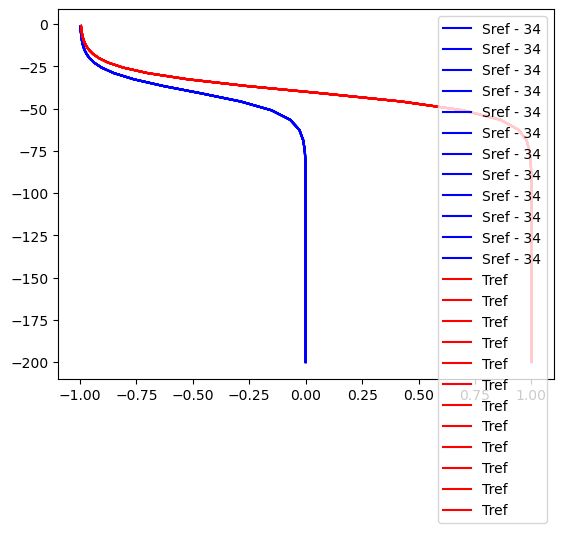

In [25]:
# Temperature profile
tcd = 40
Tmin = -1
Tmax = 1
Tc = (Tmax + Tmin) / 2
Trange = Tmax - Tmin
T2 = np.zeros([grid_params['Nr'],grid_params['Ny']])
for j in np.arange(0,grid_params['Ny']):
    T2[:,j] = Tc - Trange / 2 * np.tanh(np.pi * (z + tcd) / tcd)
Tconst = np.zeros([grid_params['Nr'],grid_params['Ny']]) + 0.4
T = T2

Sc = 33.5
Srange = -1
S2 = np.zeros([grid_params['Nr'],grid_params['Ny']])
for j in np.arange(0,grid_params['Ny']):
    S2[:,j] = Sc + Srange / 2 * np.tanh(np.pi * (z + tcd) / tcd)
Sconst = np.zeros([grid_params['Nr'],grid_params['Ny']]) + 35

S = S2

Rref = rho0 * (1 - talpha * (T - T0) + sbeta * (S - S0))

t = np.zeros([grid_params['Nr'],grid_params['Ny'],grid_params['Nx']])
s = np.zeros([grid_params['Nr'],grid_params['Ny'],grid_params['Nx']])

for j in np.arange(0,grid_params['Ny']):
    for k in np.arange(0, grid_params['Nr']):
        t[k, j, :] = t[k, j, :] + T[k,j]
        s[k, j, :] = s[k, j, :] + S[k,j]

ubound = np.zeros([grid_params['Nr'],grid_params['Ny']])

write_bin("T.init", t)
write_bin("S.init", s)
write_bin("S.bound", S)
write_bin("T.bound", T)
write_bin("U.bound", ubound)

plt.plot(S - 34, z, 'b', label="Sref - 34")
plt.plot(T, z, 'r', label="Tref")
plt.legend()
plt.savefig("%sinitialTS" % (run_config['run_dir']+'/input/'))
plt.show()

topog.slope (12, 50)


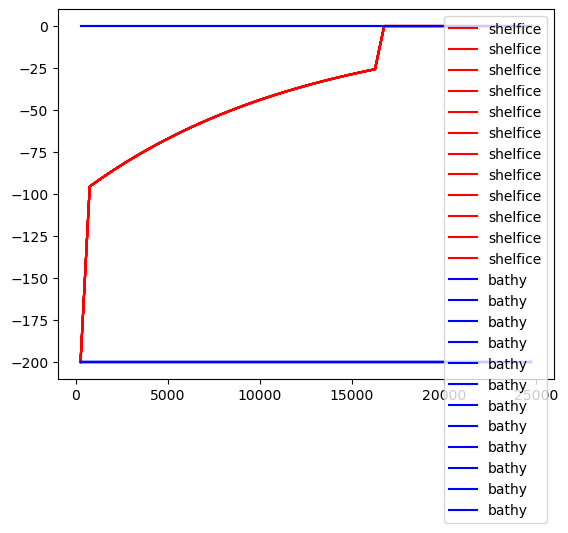

icetopo.exp1 (12, 50)
phi0.exp1 (12, 50)


In [26]:
# Topography
d = np.zeros([grid_params['Ny'], grid_params['Nx']]) - domain_params['H']
d[0, :] = 0
d[-1, :] = 0
write_bin("topog.slope", d)

# Ice shelf


m = np.zeros([grid_params['Ny'], grid_params['Nx']]) - 1
iceshelf = np.zeros([grid_params['Ny'], grid_params['Nx']])
m = np.zeros([grid_params['Ny'], grid_params['Nx']])

mX=np.load('%smelangeX.npy' % (run_config['run_dir']+'/input/'))
mH=np.load('%smelangeH.npy' % (run_config['run_dir']+'/input/'))

for j in np.arange(0, grid_params['Ny']):
    # print(j)
    #for i in np.arange(0,nx):
    iceshelf[j,:] = np.interp(x[j,:],mX,-mH,0,0)

iceshelf[:, 0] = -domain_params['H']



plt.plot(np.transpose(x), np.transpose(iceshelf), 'r', label="shelfice")
plt.plot(np.transpose(x), np.transpose(d), 'b', label="bathy")
plt.legend()
plt.savefig("%sgeo" % (run_config['run_dir']+'/input/'))
plt.show()

write_bin("icetopo.exp1", iceshelf)

# Phi 0

pano = np.zeros([grid_params['Ny'], grid_params['Nx']])
for j in np.arange(0,grid_params['Ny']):
    for i in np.arange(0, grid_params['Nx']):
        ki = np.where(z >= iceshelf[j,i])[0]

        if not ki.size > 0:
            pextra = 0
            panoex = 0
            ptop = 0
        else:
            #need to ensure Paul did this correctly for arbitraty dz spacing
            k = np.nanmax(ki)
            ptop = np.sum(Rref[0:k,j] * gravity * dz[0:k])  # Ice pressure
            ptopano = ptop - np.sum(rho0 * gravity * dz[0:k+1])  # Ice pressure anomaly
            pextra = abs(z[k] - iceshelf[j,i]) * gravity * rho0
            panoex = pextra - abs(z[k] - iceshelf[j,i]) * gravity * Rref[k,j]

        pano[j, i] = panoex + ptopano


write_bin("phi0.exp1", pano)


In [27]:
k

14

## Estimate wall clock time

## Next steps

Once you've successfully set up the model experiment, you will need to do the following:

+ Navigate to the build directory and compile the code (i.e., `bash ../makeBuild ../../..`). This may take a couple minutes and will generates lots of new files in the build directory. The key file is the `mitgcmuv` executable.



+ Next, go to the results directory and submit the job to Sherlock queue or run directly if a test (`bash ../makeRun`). It is recommended that you do this from a login node. This should generate a unique output_xxx file, which logs error messages for each run. You will get emails when the job is released from the queue and when it is completed. Test runs normally take a few minutes. A successful run will generate dozens of output files, including data files like `THETA_inst_000000.data`. 


To check if the job is running:   `squeue | grep ejdawson`
